In [ ]:
%pip install gymnasium[classic-control]
%pip install tensorflow
%pip install tdqm


import numpy as np
import tensorflow as tf
import gymnasium as gym
import os
import datetime
import random
from tqdm import tqdm
from gymnasium import wrappers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from collections import deque

Use GPU


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available:  0


Game Visualization

In [ ]:
env = gym.make('MountainCar-v0',render_mode="human")
print(env.observation_space.shape)
print(len(env.observation_space.sample()))

(2,)
2


Notice that in mountain car you should use truncated flag to terminate the episode, since at initial steps the flag might not be reached

In [ ]:
env = gym.make('MountainCar-v0')
observation, info = env.reset()

episodes = 2

for episode in range(1, episodes + 1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample()  # pick random action as policy
        obs, reward, done, truncated, info = env.step(action)
        print(obs)
        if obs[0] >= 0.1:
            print(obs)
        if truncated:
            break
        score += reward

    print(f"Episode {episode}, Score: {score}")


env.close()

We use two network of the same type, one for traininig and one which is periodically updated with new weights.Since the real target will change each time the model updates itself the solution is to create a target network that is essentially a copy of the training model at certain time steps so the target model updates less frequently
In train function we update the target value of the train model with r if it's a terminal state, otherwise we use the Bellamn equation, this makes sense because in a terminal state, there are no more future states or actions to consider, so the only contribution to the agent's total expected reward is the immediate reward associated with reaching that terminal state.

Here the metric is "accuracy" and the loss is "MeanSquaredError"
Metric functions are similar to loss functions, except that the results from evaluating a metric are not used when training the model. Note that you may use any loss function as a metric.



In [24]:
class RLAgent:
    def __init__(self,num_states,actions,gamma,lr) -> None:
        self.num_states = num_states
        self.actions = actions
        self.gamma = gamma
        self.lr = lr
        self.target_net = self.build_model()
        self.train_net = self.build_model()


    def save_model(self,eps):
        self.train_net.save('./trainNetwork{}.h5'.format(eps))

    def load(self,eps):
        self.train_net = load_model('./trainNetwork{}.h5'.format(eps))

    def build_model(self):
        """
        Builds a deep neural net which predicts the Q values for all possible
        actions given a state. The input should have the shape of the state
        (which is 2 in MountainCar), and the output should have the same shape as
        the action space (which is 2 in MountainCar) since we want 1 Q value per
        possible action.

        :return: the Q network
        """

        # apply learning rate EsponentialDecay
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            self.lr,
            decay_steps=50000,
            decay_rate=0.96,
            staircase=True
        )

        opt = tf.optimizers.Adam(learning_rate=self.lr)


        model = Sequential()
        model.add(Dense(24, input_shape=(self.num_states,), activation='relu', kernel_initializer='he_uniform'))
        #model.add(Dropout(0.5))  # Add dropout after the first dense layer
        #model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        #model.add(Dropout(0.08))  # Add dropout after the second dense layer
        model.add(Dense(48, activation='relu', kernel_initializer='he_uniform'))
        #model.add(Dropout(0.5))  # Add dropout after the third dense layer
        model.add(Dense(self.actions, activation='linear', kernel_initializer='he_uniform'))
        model.compile(optimizer=opt, loss='mse', metrics=["mse"])
        return model

    def policy(self,state):
        action_q = self.train_net(np.atleast_2d(state))
        return np.argmax(action_q[0], axis=0)


    def get_action(self,state,epsilon):
        """
        Get an action with an epsilon greedy policy
        """
        greedy = random.random() > epsilon

        # exploitation
        if greedy:

            # use the train net to get the action value given a state
            return self.policy(state)

        # exploration
        else:
             return np.random.choice(self.actions)

    def train(self, batch):
        """
        Train the network with a batch sample using a train net and a target net
        """

        state, next_state, action, reward, terminated = batch

        # get the current q value for that state, it will be a value for both actions
        current_q = self.train_net(state)

        # copy that value of the current q-value into a target variable
        target_q = np.copy(current_q)

        # using the target network get the q-value of the next state
        #next_q = self.target_net(next_state)
        next_q = self.train_net(next_state)

        # among the q-values returned by the target network select the best
        max_next_q = np.amax(next_q, axis=1)

        for i in range(state.shape[0]):

            target_q[i][action[i]] = reward[i] + self.gamma * (1 - terminated[i]) * max_next_q[i]


        # fit the train model
        result = self.train_net.fit(x=state, y=target_q, epochs=1,verbose=0)

        # return the loss
        return result.history['loss'][0]


    def update_target_network(self):
        """
        Update target network with weights of train network
        """
        self.target_net.set_weights(self.train_net.get_weights())

Why Replay buffer?
More Efficient Use of Samples: RL agents often experience a high sample complexity, requiring a large number of interactions with the environment to learn effectively. The replay buffer enables more efficient use of these samples by reusing them multiple times during training. It allows the agent to extract more information from each sample and learn from diverse experiences without needing to interact with the environment at every training step.

Stability and Convergence: Using a replay buffer can improve the stability and convergence of RL algorithms. By breaking the correlation between consecutive samples and providing a more diverse training dataset, it reduces the variance of updates and prevents the agent from getting stuck in suboptimal states. This stability promotes better convergence and more robust learning.

In [ ]:
class ReplayBuffer:
  def __init__(self,exp_max_size,batch_size):
    self.exp_max_size = exp_max_size
    self.batch_size = batch_size
    self.experiences = deque(maxlen=exp_max_size)

  def get_exp_size(self):
    """
    Get experiences length
    """
    return len(self.experiences)

  def add_experience(self,exp):
    """
    Add new experience to buffer
    """
    # oldest item are automatically removed when dimensione is over max_exp_size
    self.experiences.append(exp)


  def sample_game_batch(self):
    """
    Sample game batch for training loop
    """
    # take a sample of batch size
    sampled_gameplay_batch = random.sample(self.experiences, self.batch_size)

    # define state, next_state, action ,reward, done
    state_batch, next_state_batch, action_batch, reward_batch, done_batch= [], [], [], [], [],

    # for each experience in the batch get a sample
    for gameplay_experience in sampled_gameplay_batch:
      state_batch.append(gameplay_experience[0])
      next_state_batch.append(gameplay_experience[1])
      reward_batch.append(gameplay_experience[2])
      action_batch.append(gameplay_experience[3])
      done_batch.append(gameplay_experience[4])


    # TODO check if it works and why numpy array only for first two
    return np.array(state_batch), np.array(next_state_batch), np.array(action_batch), np.array(reward_batch), np.array(done_batch)

Helper function used to evaluate training process, it returns the average rewards of 10 episode. Notice that the action is taken according to the currently learned policy and not with epsilon greedy policy

In [21]:
import matplotlib.pyplot as plt

def plot_avg_rew(episode_cnt,avg_rewards):

    plt.plot(range(episode_cnt), avg_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Average Reward per Episode')
    plt.ylim(-200, None)
    plt.show()

def plot_policy(actions):
    temp_action_x = list(actions.keys())

    action_labels = {0: "left", 1: "stay", 2: "right"}
    action_x = [action_labels[a] for a in temp_action_x]
    action_y = list(actions.values())

    colors = ['blue', 'green', 'orange']

    fig, ax = plt.subplots()
    ax.bar(action_x, action_y, color=colors)
    ax.set_ylabel('Ocurrences')
    ax.set_title('Actions')
    ax.legend(title='Actions policy')

    plt.show()

 16%|█▌        | 16/100 [00:00<00:01, 75.83it/s]

0/100


 24%|██▍       | 24/100 [00:00<00:01, 66.85it/s]

20/100


 46%|████▌     | 46/100 [00:00<00:00, 64.03it/s]

40/100


 72%|███████▏  | 72/100 [00:01<00:00, 53.65it/s]

60/100


 90%|█████████ | 90/100 [00:01<00:00, 50.79it/s]

80/100


100%|██████████| 100/100 [00:01<00:00, 56.99it/s]


Average reward: -200.0, Accuracy 0.0000


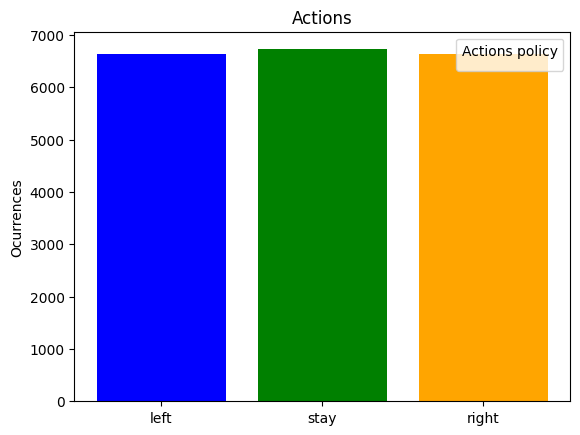

In [23]:
def training_result():

  env = gym.make('MountainCar-v0')

  total_reward = 0.0
  win = 0
  episodes = 100
  actions = {0:0,
             1:0,
             2:0}

  agent = RLAgent(num_states=len(env.observation_space.sample()),actions=env.action_space.n,gamma=0.99,lr=0.001251)
  agent.load("2500")


  for i in tqdm(range(episodes)): # Play 10 episode and take the average
    state, _ = env.reset()
    done = False
    truncated = False
    episode_reward = 0.0
    while not (done or truncated):
      #action = agent.policy(state)
      action = np.random.choice(env.action_space.n)
      next_state, reward, done,truncated, info = env.step(action)

      # increment action
      actions[action] += 1


      # Count number of win
      if next_state[0] >= 0.5:
        win += 1

      episode_reward += reward
      state = next_state

    if i % 20 == 0:
        print(f"{i}/{episodes}")

    total_reward += episode_reward

  average_reward = total_reward / episodes
  accuracy = win / episodes

  print(f"Average reward: {average_reward}, Accuracy {accuracy:.4f}")
  plot_policy(actions)


training_result()


Training loop

In [ ]:
import time

EPISODE = 3000             # number of episode to play
EPISODE_MAX_LENGTH = 200
UPGRADE_STEP = 20            # frequency of target network upgrade
SAVE_MODEL_STEP = 500        # frequency of saving model
GAMMA = 0.99                # discount factor
EXP_MAX_SIZE = 20_000         # Max batch size of past experience
EXP_MIN_SIZE = 1500           # Min batch size of past experience
LR = 0.001251               # NN learning rate
EPS_MAX = 1.0               # Initial exploration probability
EPS_MIN = 0.00001           # Final exploration probability
#DECAY = 1-EPS_MAX/EPISODE  # Defines scaling factor of epsilon
DECAY = 0.85
BATCH_SIZE = 32            # Sample to get from experiences

# Start with high exploration probability
epsilon = EPS_MAX

reward_sum = 0
win = 0
scores = list()

env = gym.make('MountainCar-v0')
agent = RLAgent(num_states=len(env.observation_space.sample()),actions=env.action_space.n,gamma=GAMMA,lr=LR)
buffer = ReplayBuffer(exp_max_size=EXP_MAX_SIZE,batch_size=BATCH_SIZE)
time_scores = deque(maxlen=100)

#agent.load("200")

start = time.time()
for episode_cnt in range(EPISODE):
  state, _ = env.reset()
  terminated = False

  # play the game and collect experience
  for step in range(EPISODE_MAX_LENGTH):
    action = agent.get_action(state,epsilon)
    next_state, reward, terminated, truncated, _ = env.step(action)

    # add experience tu the buffer
    buffer.add_experience((state, next_state, reward, action, terminated))

    # agent won't start learning if there isn't enough experience
    if buffer.get_exp_size() > BATCH_SIZE and step % 15 == 0:
        gameplay_experience_batch = buffer.sample_game_batch()
        loss = agent.train(gameplay_experience_batch)

    # set state to next state
    state = next_state


    if terminated or truncated:

        # store current time for that episode
        time_scores.append(step)

        # compute avg score
        scores_avg = np.mean(time_scores) * -1

        #if episode_cnt % 250 == 0:
            # store avg score
        scores.append(scores_avg)

        # if goal increase number of win
        if next_state[0] >= 0.5:
            win += 1

        print(f"Episode {episode_cnt}/{EPISODE}, e {epsilon:.6f}, exp size {buffer.get_exp_size()}, avg reward {scores_avg:.2f}, state {state}, time {step}, win {win}")
        break

#   if buffer.get_exp_size() > BATCH_SIZE:
#         gameplay_experience_batch = buffer.sample_game_batch()
#         loss = agent.train(gameplay_experience_batch)


  # update target network after one episode playing
  #if episode_cnt % UPGRADE_STEP == 0 and episode_cnt > 0:
  #agent.update_target_network()

  # decay epsilon to increase exploitation probability
  epsilon = max(EPS_MIN, epsilon * DECAY)

  if episode_cnt % SAVE_MODEL_STEP == 0 and episode_cnt > 0:
    agent.save_model(episode_cnt)

  # display results
  if episode_cnt % 2999 == 0 and episode_cnt > 0:
    plot_avg_rew(episode_cnt+1,scores)


end = time.time()

print(f"Learning duration: {end-start:.3f}")

# plot reward score
plot_avg_rew(EPISODE,scores)
training_result(env,agent)

Execution only with train net, then check execution with target net and report:



*   Average reward: -137.273 after 3000 Accuracy 0.74 with % 10 no target_net no dropout
*   Average reward: -125.276 after 3000 episodes with % 15, Accuracy 0.9910 no target_net no dropout

